## Import libraries

In [2]:
!pip install mediapipe
import pandas as pd
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [4]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d rakibuleceruet/drowsiness-prediction-dataset
!kaggle datasets download -d adinishad/prediction-images

Dataset URL: https://www.kaggle.com/datasets/rakibuleceruet/drowsiness-prediction-dataset
License(s): unknown


In [ ]:
!unzip drowsiness-prediction-dataset.zip
!unzip prediction-images.zip

In [4]:
import os

In [6]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

Image preprocessing

In [6]:
import mediapipe as mp
import numpy as np
mp_facemesh = mp.solutions.face_mesh
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [8]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt

    # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [10]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [13]:
import cv2
import mediapipe as mp




def face_for_yawn(direc="/Users/rupeshsaini/Desktop/Driver-Drowsiness-Detection-main/content/0 FaceImages", face_cas_path="/Users/rupeshsaini/Desktop/Driver-Drowsiness-Detection-main/content/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

I0000 00:00:1745297107.365828 1803411 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1745297107.366597 1868370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745297107.369001 1868376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1745297107.393734 1803411 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1745297107.394432 1868377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745297107.396812 1868382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1745297107.436286 1803411 gl_context

0


I0000 00:00:1745297107.502034 1803411 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1745297107.502786 1868402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745297107.505222 1868402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1745297107.544039 1803411 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1745297107.544839 1868413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745297107.547280 1868413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1745297107.576057 1803411 gl_context

1


I0000 00:00:1745297274.688477 1803411 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1745297274.689297 1899696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745297274.691839 1899696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1745297274.722375 1803411 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1745297274.723132 1899703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745297274.725547 1899703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1745297274.757651 1803411 gl_context

In [30]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3870


In [17]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3673


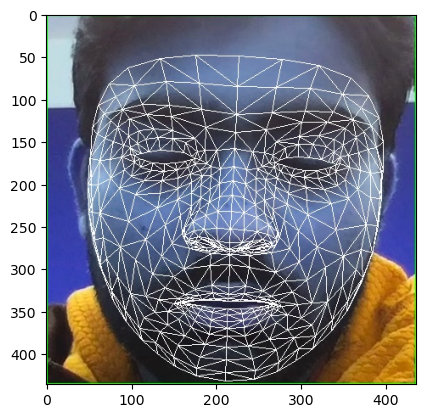

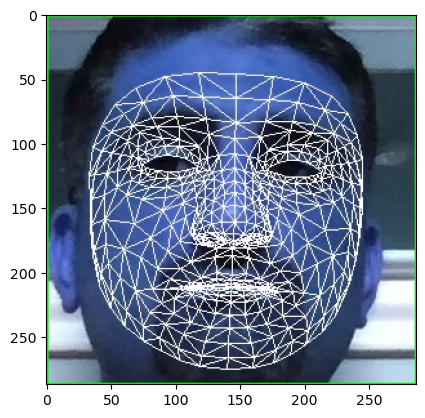

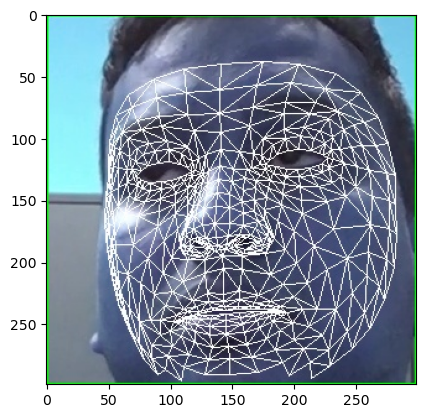

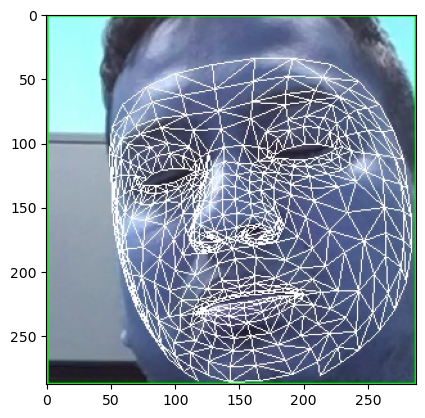

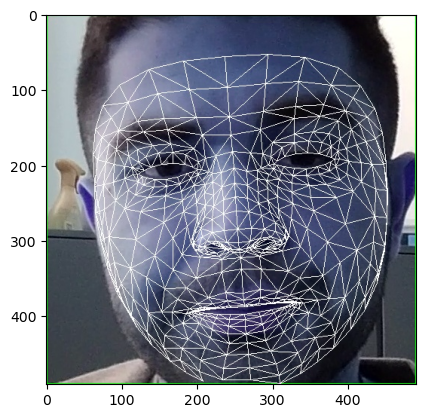

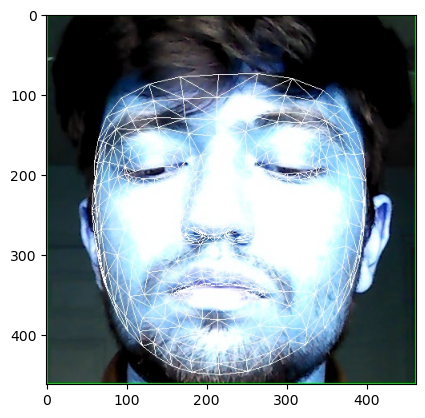

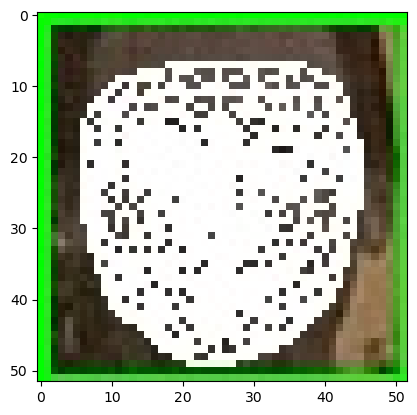

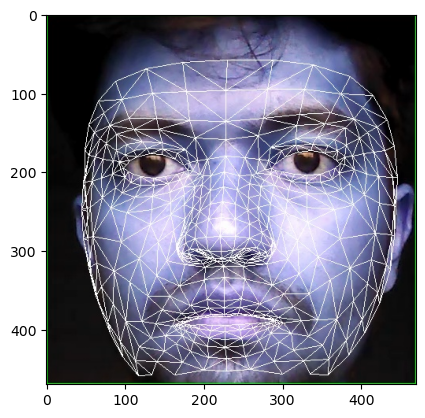

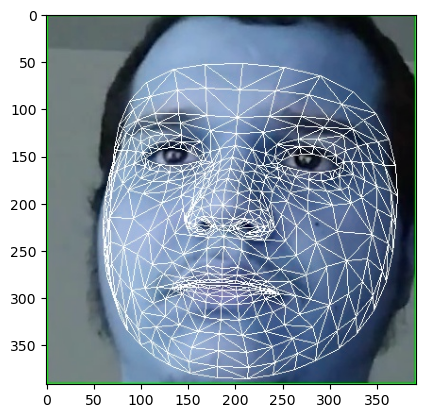

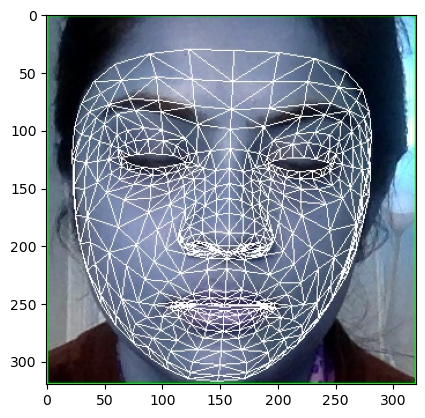

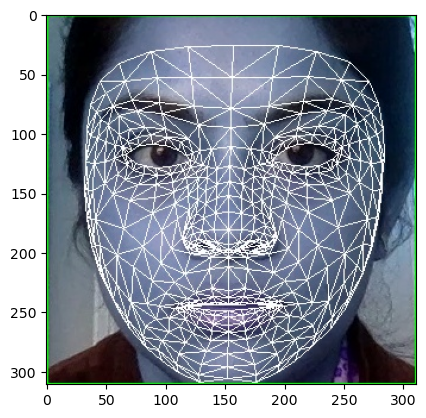

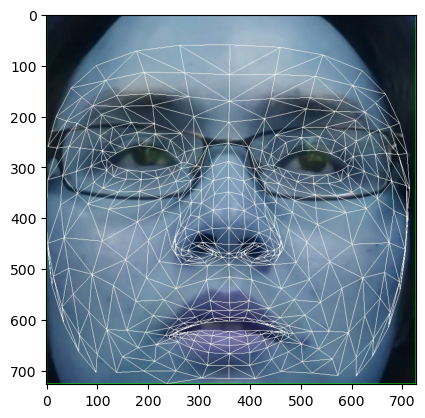

In [26]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

Resizing Images

In [70]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        print(path_link)
        class_num1 = categories.index(category)
        print(class_num1)
        
        for image in os.listdir(path_link):
            
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            if image_array is not None:
                
                
                
                
                

                print(f"Loaded image shape: {image_array.shape}")
            
                resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

./Fatigue Subjects
0
Loaded image shape: (436, 436, 3)
Loaded image shape: (287, 287, 3)
Loaded image shape: (299, 299, 3)
Loaded image shape: (288, 288, 3)
Loaded image shape: (491, 491, 3)
Loaded image shape: (462, 462, 3)
Loaded image shape: (310, 310, 3)
Loaded image shape: (485, 485, 3)
Loaded image shape: (284, 284, 3)
Loaded image shape: (255, 255, 3)
Loaded image shape: (270, 270, 3)
Loaded image shape: (825, 825, 3)
Loaded image shape: (181, 181, 3)
Loaded image shape: (853, 853, 3)
Loaded image shape: (283, 283, 3)
Loaded image shape: (419, 419, 3)
Loaded image shape: (496, 496, 3)
Loaded image shape: (494, 494, 3)
Loaded image shape: (443, 443, 3)
Loaded image shape: (550, 550, 3)
Loaded image shape: (290, 290, 3)
Loaded image shape: (448, 448, 3)
Loaded image shape: (266, 266, 3)
Loaded image shape: (280, 280, 3)
Loaded image shape: (188, 188, 3)
Loaded image shape: (507, 507, 3)
Loaded image shape: (190, 190, 3)
Loaded image shape: (165, 165, 3)
Loaded image shape: (407, 4

Seperate label and features

In [72]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

Reshape the array

In [76]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

Label encoder

In [78]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

Splitting

In [80]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [82]:
len(X_test)

1509

In [84]:
len(X_train)

6034

In [86]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Data Augmentation

In [88]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Model

In [90]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Flatten
)
from tensorflow.keras.optimizers import Adam

# Define the MobileNet as the base model
base_model = MobileNet(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude fully connected layers
    input_shape=(145, 145, 3)
)

# Freeze the base model layers to use them as feature extractors
base_model.trainable = False

# Build the custom model on top of MobileNet
model_input = Input(shape=(145, 145, 3))
x = base_model(model_input)
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=model_input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


/var/folders/wg/ky2qmbrd78g3snmmqr4583680000gn/T/ipykernel_58962/877073817.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 288s 17us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 145, 145, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,369,153 (12.85 MB)

 Trainable params: 139,905 (546.50 KB)

 Non-trainable params: 3,229,248 (12.32 MB)

In [96]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout, LSTM, Reshape, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

# Define the MobileNet as the base model
base_model = MobileNet(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude fully connected layers
    input_shape=(145, 145, 3)  # Set to default MobileNet input size
)

# Freeze the base model layers to use them as feature extractors
base_model.trainable = False

# Add new layers for our specific task
model_input = Input(shape=(145, 145, 3))  # Match input shape of MobileNet
x = base_model(model_input)

# Global average pooling layer
x = GlobalAveragePooling2D()(x)  # Output: (batch_size, features)

# Add LSTM-compatible reshaping
x = Reshape((1, -1))(x)  # Reshape to (batch_size, time_steps, features)

# Add LSTM for sequence processing
x = LSTM(64, return_sequences=False)(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=model_input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/var/folders/wg/ky2qmbrd78g3snmmqr4583680000gn/T/ipykernel_58962/4100350903.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 145, 145, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,524,801 (13.45 MB)

 Trainable params: 295,681 (1.13 MB)

 Non-trainable params: 3,229,120 (12.32 MB)

In [98]:
# Train the model
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=test_generator
)

# Save the trained model
model.save('mobileNet_finetuned_model.h5')


Epoch 1/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.6071 - loss: 0.7121 - val_accuracy: 0.7482 - val_loss: 0.5902
Epoch 2/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.7213 - loss: 0.5522 - val_accuracy: 0.7813 - val_loss: 0.4850
Epoch 3/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.7653 - loss: 0.4981 - val_accuracy: 0.8125 - val_loss: 0.4285
Epoch 4/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.7754 - loss: 0.4769 - val_accuracy: 0.8078 - val_loss: 0.4102
Epoch 5/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7990 - loss: 0.4406 - val_accuracy: 0.8005 - val_loss: 0.3991
Epoch 6/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7961 - loss: 0.4091 - val_accuracy: 0.8184 - val_loss: 0.3732
Epoch 7/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.8077 - loss: 0.4091 - val_accuracy: 0.8257 - val_loss: 0.3588
Epoch 8/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.8126 - loss: 0.3967 - 

In [100]:
model.save('mobileNet_finetuned_model.keras')

In [102]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8879 - loss: 0.2408
Test Loss: 0.2675563097000122
Test Accuracy: 0.8840291500091553


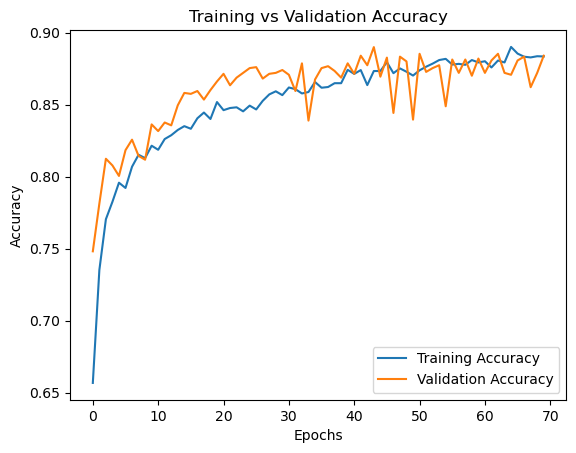

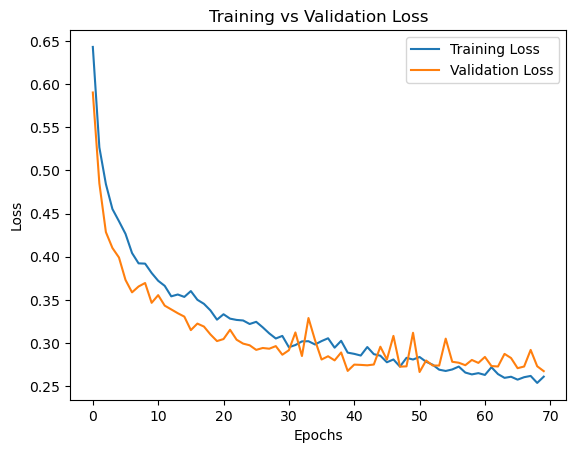

In [104]:
# Optionally, plot training and validation accuracy/loss
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [106]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8879 - loss: 0.2408


{'loss': 0.2675563097000122, 'compile_metrics': 0.8840291500091553}

In [ ]:
from tensorflow.keras.applications import MobileNetV2 # Importing MobileNetV2 class
from tensorflow.keras.layers import Dense, Flatten # Importing Dense, Flatten layers for layer definition
from tensorflow.keras.models import Model  # Importing Model class for model definition
import keras
from tensorflow.keras.optimizers import Adam  # Importing Adam optimizer for model compilation
# Rest of the code remains unchanged

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(145, 145, 3),
)
type(base_model)
base_model.summary()
model=keras.Sequential()
for layer in base_model.layers[:-25] :
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

model.compile(optimizer=Adam(0.0001 ), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
   train_batches,
    epochs=10,
    validation_data=val_batches,
    batch_size=32
)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions on the test set
y_pred = model.predict(test_generator, verbose=1)

# Convert predictions to binary values
y_pred = np.round(y_pred)

# Get all batches from the test generator
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)

# Convert the list of labels to a NumPy array
y_true = np.array(y_true)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Print the classification report
print("Classification Report:")
print(report)

# Calculate precision, recall, and F1 score individually (for binary classification)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print precision, recall, and F1 score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence

# Define the sequence length
sequence_length = 10

# --- Data Preparation ---
# Reshape data for TimeDistributed layers
def reshape_data(data, labels, sequence_length):
    """Reshapes data and labels to create sequences for TimeDistributed layers."""
    num_sequences = data.shape[0] // sequence_length
    data_sequences = data[:num_sequences * sequence_length].reshape(num_sequences, sequence_length, 145, 145, 3)
    # Reshape labels to match the number of sequences
    labels_sequences = labels[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
    # Take the last label of each sequence
    labels_sequences = labels_sequences[:, -1]
    return data_sequences, labels_sequences

class TimeDistributedImageDataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, image_data_generator):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.image_data_generator = image_data_generator

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Apply augmentations to each image in the sequence
        for i in range(batch_x.shape[0]):
            for j in range(batch_x.shape[1]):
                batch_x[i, j] = self.image_data_generator.random_transform(batch_x[i, j])

        return batch_x, batch_y

# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1/255)

# Create custom generators
train_generator = TimeDistributedImageDataGenerator(X_train_sequences, y_train_sequences, batch_size=32, image_data_generator=train_datagen)
test_generator = TimeDistributedImageDataGenerator(X_test_sequences, y_test_sequences, batch_size=32, image_data_generator=test_datagen)



# Define the model
model = Sequential()

# Add the CNN layers with Batch Normalization and Dropout
model.add(TimeDistributed(Conv2D(16, 3, activation='relu', padding='same'), input_shape=(sequence_length, 145, 145, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv2D(32, 5, activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv2D(64, 10, activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv2D(128, 12, activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Flatten()))

# Add the LSTM layer to process the sequence of CNN outputs
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.25))

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

# Display the model summary
model.summary()

## Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set up callbacks
callbacks = [
    ModelCheckpoint(
        filepath='best_model.keras',  # Save the best model during training
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Stop training if no improvement for 10 epochs
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1  # Display progress during training
)


## Testing

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

## Saving the model

In [ ]:
model.save('my_model.h5')
#model = tf.keras.models.load_model('my_model.h5')

Testing the model

In [112]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.8 kB/s eta 0:00:0000:0100:01


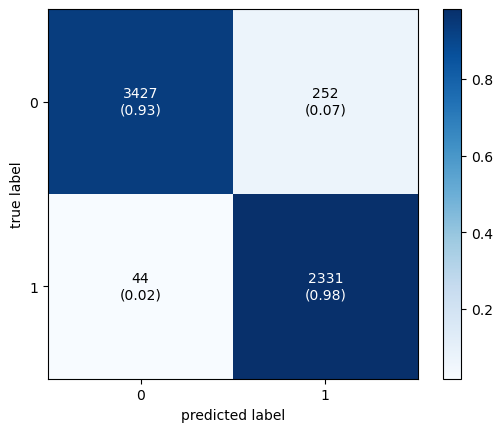

In [114]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [120]:
!pip install pydot

In [122]:
# Instead of using keras.utils.vis_utils, use tensorflow.keras.utils:
from tensorflow.keras.utils import plot_model

# The rest of your code should work as expected:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.


FileNotFoundError: No such file or directory: 'model.png'

FileNotFoundError: No such file or directory: 'model.png'

<IPython.core.display.Image object>

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)

In [ ]:
!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

#TEST THE MODEL ON IMAGES FROM WEB

In [5]:
import cv2
import numpy as np
from tensorflow import keras
import urllib.request
import matplotlib.pyplot as plt

In [7]:
model = keras.models.load_model('mobileNet_finetuned_model.keras')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
import cv2
import os
import numpy as np

# Load the video
video_path = '/Users/rupeshsaini/Desktop/Driver-Drowsiness-Detection-main/Test/1.mp4'
output_dir = 'frames'
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_num = 0
fatigue=0
active=1

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_num += 1
    IMG_SIZE = 145
    
    
    
    
    # Check if image is loaded
    if frame is None:
        print("Failed to load image. Check the path:")
    else:
        # Resize the image
        image = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    
        # Normalize the image (convert pixel values from 0-255 to 0-1)
        image = image / 255.0
    
        # Add batch dimension (for model input, e.g., shape becomes [1, 145, 145, 3])
        image = np.expand_dims(image, axis=0)
        prediction = model.predict(image)
        if prediction[0][0] < 0.5:
            
            fatigue=fatigue+1
        else:
            active=active+1
           
    
        
    

cap.release()
if fatigue>active:
    print("fatigue")
else:
    print("active")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [25]:
import cv2
import numpy as np

IMG_SIZE = 145
image_path = '/Users/rupeshsaini/Desktop/Driver-Drowsiness-Detection-main/Test/4.jpeg'

# Load the image in color (BGR format)
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Check if image is loaded
if image is None:
    print("Failed to load image. Check the path:", image_path)
else:
    # Resize the image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Normalize the image (convert pixel values from 0-255 to 0-1)
    image = image / 255.0

    # Add batch dimension (for model input, e.g., shape becomes [1, 145, 145, 3])
    image = np.expand_dims(image, axis=0)

    print("Image loaded and preprocessed. Shape:", image.shape)

Image loaded and preprocessed. Shape: (1, 145, 145, 3)


In [27]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


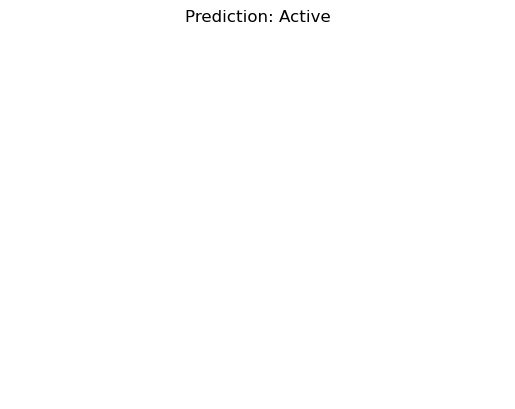

In [29]:

plt.title(f'Prediction: {"Fatigue" if prediction[0][0] < 0.5 else "Active"}')
plt.axis('off')
plt.show()